In [90]:
### Setting the environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import requests
from textwrap import wrap
import merge_data as md

In [142]:
import importlib
importlib.reload(md)

### calls merge_data.py to combine data from the 4 sources (arcgis, ckan, usmart, google sheets)
data = md.merge_data()
print (str(len(data)) + ' rows loaded')

1171 rows loaded


In [92]:
### Additional cleaning
### Removed 'Council' from all labels for brevity in visual displays.
data['Owner'] = data['Owner'].str.replace(' Council','')

### New dataset: Distinct datasets by council
data_distinct = data[['Owner','Title','PageURL','Source']]
data_distinct = data_distinct.drop_duplicates()

### Loading list of local authorities (from wikidata)
data_localauthorities = pd.read_csv('../data/local_authorities_list.csv').rename(columns={'itemLabel':'Council'})
data_localauthorities['Council'] = data_localauthorities['Council'].str.replace(' Council','')

### Quality check: These owners in dataset cannot be matched to the appropriate council names
owners = pd.DataFrame(set(data['Owner'])).rename(columns={0:'Owner'})
owners = owners.merge(data_localauthorities, how='left', left_on='Owner', right_on='Council')
qc_owners = owners[owners['Council'].isna()]
if len(qc_owners) > 0:
    print('Quality check: These owners in dataset cannot be matched to the appropriate council names')
    qc_owners
else: None


Quality check: These owners in dataset cannot be matched to the appropriate council names


In [93]:
### default settings for plt graphs
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### function to add data labels
def addlabels(x,y,dp):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i],dp), ha = 'center')

### function to wrap axis labels
def wrapaxis(col,text_wrap):
    xlabels = [ '\n'.join(wrap(l, text_wrap)) for l in col]
    plt.xticks(range(0,len(col)),labels=xlabels)

### make standard column chart
def columnchart(title, x_col, y_col, colour):
    plt.figure(figsize=(15,3))
    fig = plt.bar(x=x_col, height=y_col, color=colour)
    plt.ylabel(''), plt.xlabel(''), plt.yticks([])
    addlabels(x_col, y_col,0)
    wrapaxis(x_col,13)
    plt.box(False)
    plt.title(title)
    plt.savefig('image_'+title+'.png')
    plt.show()

# Analysis & Scorecard
- Analysis in each area 
    - [Dataset Overview](#overview)
    - [Dataset Sources](#sources)
    - [File Types](#filetypes)
    - [File Sizes](#sizes)
    - [Dataset Tags](#tags)
    - [Dataset Licensing](#licensing)
    - [URL Statuses](#urls)
- [Summary Matrix](#summary)
- [Scorecard](#scorecard)

In [94]:
print('Generated: ', dt.datetime.now().strftime('%d-%b-%Y %H:%M'))

Generated:  19-Feb-2022 16:34


<a id='overview'></a>
## Dataset Overview
An overview of the OD files available and which councils provide them

In [95]:
print('all data files: ', len(data))
print('distinct datasets: ', len(data_distinct))

all data files:  1171
distinct datasets:  483


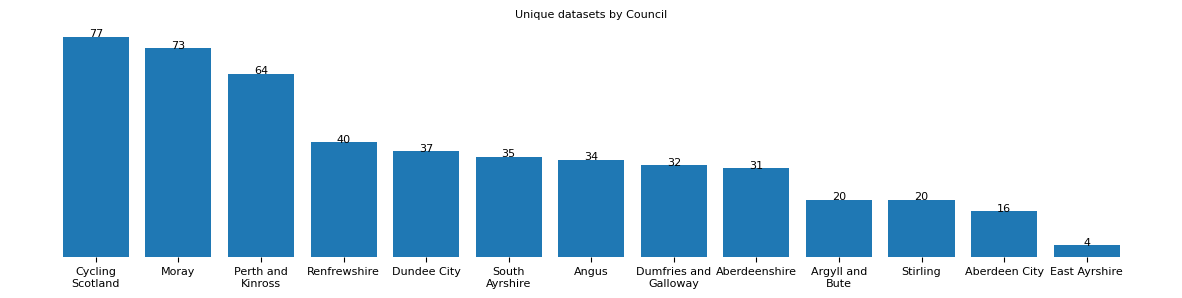

In [96]:
### Unique datasets by council
stats_a = data_distinct.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a = stats_a.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
columnchart('Unique datasets by Council', stats_a['Owner'], stats_a['Count'], colour='#1f78b4')


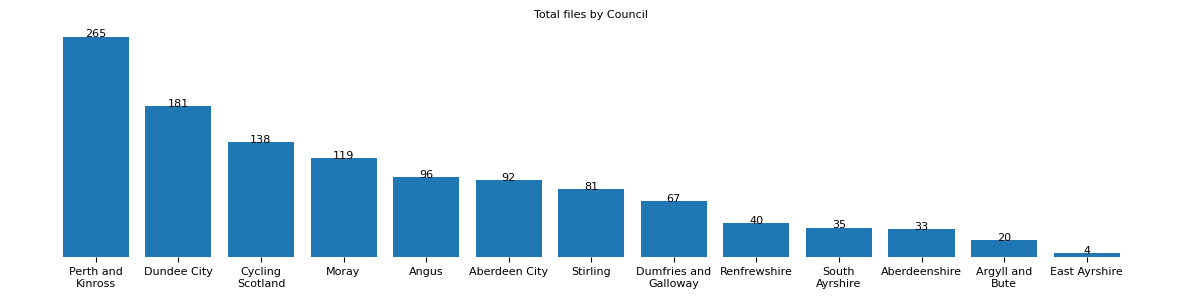

In [97]:
### Unique datasets by council
stats_a1 = data.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a1 = stats_a1.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
columnchart('Total files by Council', stats_a1['Owner'], stats_a1['Count'], colour='#1f78b4')

<a id='sources'></a>
## Dataset Sources
Looking at how these OD files are accessed via API or by manual extraction

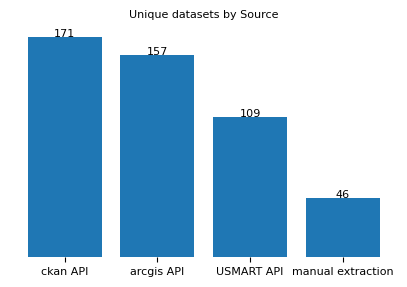

In [98]:
### Unique datasets by Source
stats_b1 = data_distinct.groupby(['Source']).size().reset_index().rename(columns={0:'Count'})
stats_b1 = stats_b1.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
plt.figure(figsize=(5,3))
plt.bar(x=stats_b1['Source'], height=stats_b1['Count'])
plt.ylabel(''), plt.xlabel(''), plt.yticks([])
addlabels(stats_b1['Source'], stats_b1['Count'],0)
plt.box(False)
plt.title('Unique datasets by Source')
plt.savefig('image_Unique datasets by Source.png')
plt.show()


In [99]:
### Unique datasets by Council and Source
stats_b = data_distinct.groupby(['Owner','Source']).size().reset_index().rename(columns={0:'Count'})
stats_b = stats_b.sort_values(by=['Count'], ascending=False)

### Unique datasets by Council and Source, as matrix
stats_b_pivot = stats_b.pivot(index='Owner',columns='Source', values='Count').reset_index()
stats_b_pivot.loc['Source_Total']= stats_b_pivot.sum(numeric_only=True, axis=0)
stats_b_pivot.loc[:,'Council_Total'] = stats_b_pivot.sum(numeric_only=True, axis=1)
stats_b_pivot = stats_b_pivot.fillna('')
stats_b_pivot

Source,Owner,USMART API,arcgis API,ckan API,manual extraction,Council_Total
0,Aberdeen City,,,16.0,,16.0
1,Aberdeenshire,,,,31.0,31.0
2,Angus,,,34.0,,34.0
3,Argyll and Bute,,20.0,,,20.0
4,Cycling Scotland,77.0,,,,77.0
5,Dumfries and Galloway,32.0,,,,32.0
6,Dundee City,,,37.0,,37.0
7,East Ayrshire,,,,4.0,4.0
8,Moray,,62.0,,11.0,73.0
9,Perth and Kinross,,,64.0,,64.0


<a id='filetypes'></a>
## Filetypes
There are 27 different filetypes labelled in our dataset but the distribution is very uneven. The clear popular format is the open CSV format, but we also see some proprietary spreadsheet formats such as XLSX and the now depreciated XLS format. 

Bear in mind that several of these files will be duplicated, but in different formats. For example, KMZ is the compressed format of KML. ZIP files may contain several different formats together.


In [100]:
### Table showing counts by filetypes
pd.DataFrame(\
        data.groupby(['FileType']).size())\
    .rename(columns={0:'Count'})\
    .sort_values(by='Count', ascending=False)\
    .reset_index()
    

,FileType,Count
0,CSV,387
1,FEATURE LAYER,123
2,JSON,99
3,GEOJSON,91
4,KML,81
5,HTML,66
6,ZIP,62
7,ARCGIS GEOSERVICES REST API,36
8,XML,33
9,WMS,30


### Inconsistencies in filetype metadata

There are filetypes labelled "Table", "Image", and "Document Link" which are descriptions rather than names of file formats. All of these come from 1 council, and is suggestive of a lack of standardised labelling.

Only 13 of the 27 formats (~48%) are provided by more than 1 council, which again suggests inconsistencies, but this time it could be that the actual filetypes provided are unusual, or it could be labelling errors as before. 

Note that these labels have already been treated for inconsistencies in string formating (casing). Again, these should ideally be standardised in the publishing process.

In [101]:
### Table showing number of councils providing each filetypes
data.groupby(['FileType'])['Owner'].nunique()\
    .reset_index()\
    .sort_values(by='Owner', ascending=False)\
    .rename(columns={'Owner':'Count of Councils Providing'})\
    .reset_index(drop=True)

,FileType,Count of Councils Providing
0,CSV,10
1,ZIP,6
2,GEOJSON,6
3,PDF,5
4,XML,4
5,FEATURE LAYER,4
6,HTML,4
7,KML,4
8,JSON,3
9,XLSX,3


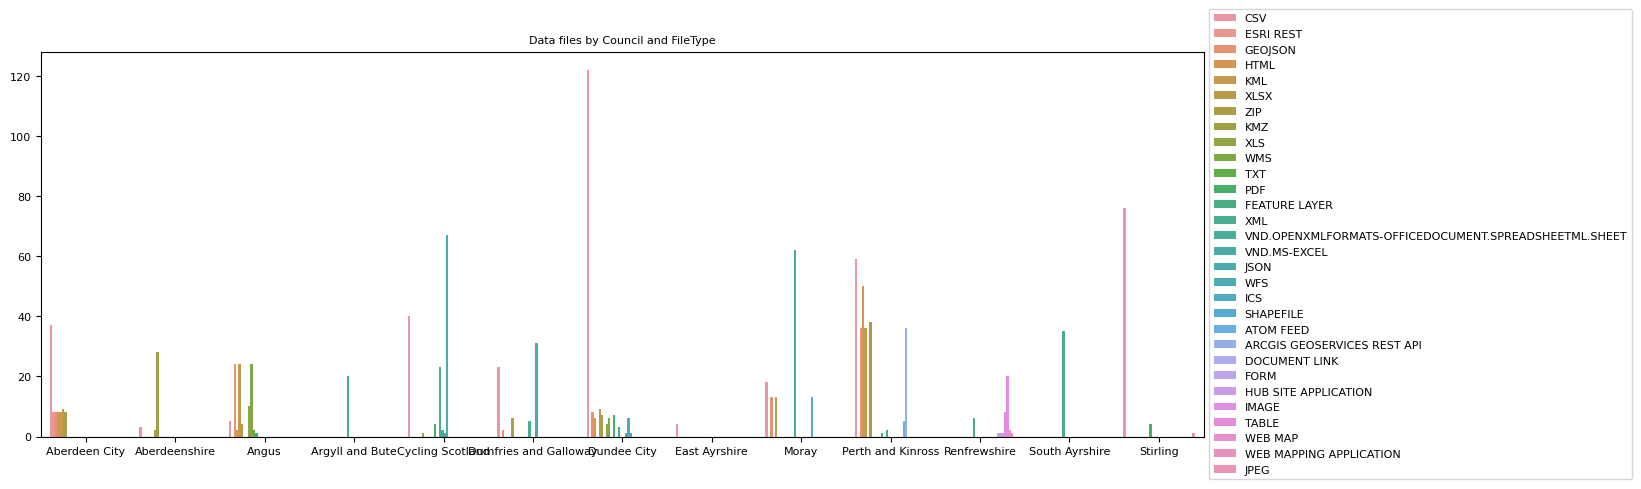

In [102]:
### Count of data files by Council and FileType, ordered by Council name
stats_c = data.groupby(['Owner','FileType']).size().reset_index().rename(columns={0:'Count'})
stats_c = stats_c.sort_values(by=['Owner'], ascending=True).reset_index(drop=True)

### Chart
plt.figure(figsize=(15,5))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Data files by Council and FileType')
plt.savefig('image_Data files by Council and FileType.png')
plt.show()


In [103]:
### Count of data files by Council and FileType, as matrix (rows=filetype, columns=council), ordered by FileType count

stats_c_pivot = stats_c.pivot(index='FileType',columns='Owner', values='Count')
stats_c_pivot.loc[:,'FileType_Total'] = stats_c_pivot.sum(numeric_only=True, axis=1)
stats_c_pivot = stats_c_pivot.sort_values(by='FileType_Total', ascending=False)
stats_c_pivot.loc['Council_Total']= stats_c_pivot.sum(numeric_only=True, axis=0)
stats_c_pivot = stats_c_pivot.fillna('')
stats_c_pivot


Owner,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Cycling Scotland,Dumfries and Galloway,Dundee City,East Ayrshire,Moray,Perth and Kinross,Renfrewshire,South Ayrshire,Stirling,FileType_Total
FileType,,,,,,,,,,,,,,
CSV,37.0,3.0,5.0,,40.0,23.0,122.0,4.0,18.0,59.0,,,76.0,387.0
FEATURE LAYER,,,,20.0,,,,,62.0,,6.0,35.0,,123.0
JSON,,,,,67.0,31.0,1.0,,,,,,,99.0
GEOJSON,8.0,,24.0,,,2.0,8.0,,13.0,36.0,,,,91.0
KML,8.0,,24.0,,,,,,13.0,36.0,,,,81.0
HTML,8.0,,2.0,,,,6.0,,,50.0,,,,66.0
ZIP,8.0,2.0,,,1.0,6.0,7.0,,,38.0,,,,62.0
ARCGIS GEOSERVICES REST API,,,,,,,,,,36.0,,,,36.0
XML,,,,,23.0,5.0,3.0,,,2.0,,,,33.0


### Average FileTypes for each dataset
This gives us an idea of the variety of file types offered per dataset. A higher average would suggest several filetypes are offered for the same data (e.g. a .csv and a .json), although with caveats. Bear in mind that 
- If there is a ZIP of multiple .csv files this counts as 2 file types. Same with KMZ and KML.
- geojson or shapefiles tend to come as a package, so councils providing a high proportion of geospatial data will naturally serve a high average number of filetypes per dataset. 

So while this measure is useful, just be aware it may just be echoing the nature of the data provided rather than a true offering of variety.

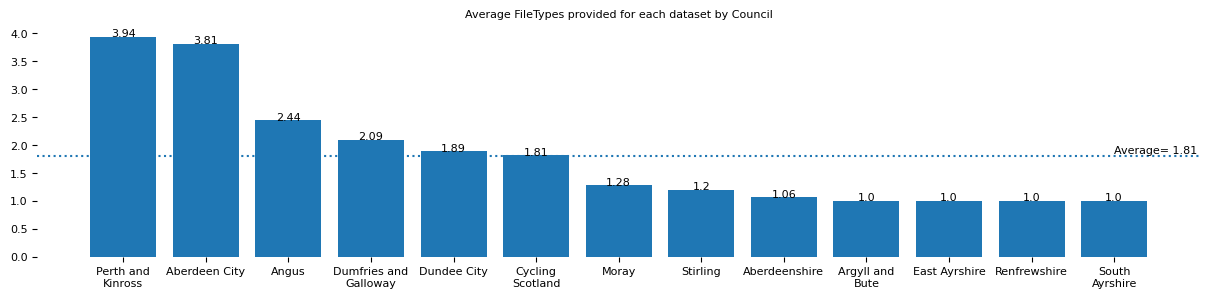

In [104]:
### Average count of filetypes provided per dataset, by council
stats_e = data.groupby(['Owner','Title'])['FileType'].nunique().reset_index()
stats_e = stats_e.groupby(['Owner'])['FileType'].mean().reset_index()
stats_e = stats_e.sort_values(by=['FileType'], ascending=False).reset_index(drop=True)
stats_e_mean = round(stats_e['FileType'].mean(),2)

### Chart

plt.figure(figsize=(15,3))
plt.bar(x=stats_e['Owner'], height=stats_e['FileType'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_e['Owner'], stats_e['FileType'],2)
wrapaxis(stats_e['Owner'],13)
plt.box(False)
plt.axhline(y=stats_e_mean, linestyle=':')
plt.text(x=len(stats_e)-1, y=stats_e_mean, s='Average= '+ str(stats_e_mean), verticalalignment='bottom')
plt.title('Average FileTypes provided for each dataset by Council')
plt.savefig('image_Average FileTypes provided for each dataset by Council.png')
plt.show()

### Bottom line 
There is a wide range of filetypes available, but this range is likely due to inconsistencies in labelling rather than a true variety of filetype offerings. The most popular filetype by far is CSV, which is offered by the most councils and also makes the largest share of all offerings.

<a id='sizes'></a>
## File size
File size isn't the best proxy for the volume of data provided, we will want to look at the number of instances or number of values per file or dataset for this. Filetypes will also have influence on total filesize: binary files such as .xlsx will be larger than their .csv equivalents, as will PDFs and images.

But file size is still interesting to look at for accessibility reasons. Mammoth files will struggle to download for users or organisations on limited bandwidth internet connections, they also take a chunk of councils' storage resources. 


In [105]:
### Convert file size units to bytes
def filesize_convert(unit, val):
    byte_conversions = {
            'bytes': 1,
            'B': 1,
            'KB': 1000,
            'MB': 1000000,
            'GB': 1000000000
        }
    if (unit in list(byte_conversions.keys())) & (val > 0):
        conv_bytes = val * byte_conversions[unit]
    else: 
        conv_bytes = None
        
    return conv_bytes

### apply conversion function
data['FileSizeBytes'] = data.apply(lambda x: filesize_convert(x['FileSizeUnit'], x['FileSize']), axis=1)
data['FileSizeBins'] = pd.cut(x=data['FileSizeBytes'], bins=[1,1000,10000,100000,1000000,10000000, 100000000, 1000000000, 10000000000], labels=['<1KB','1-10KB','10-100KB','0.1-1MB','1-10MB','10-100MB','0.1-1GB','1-10GB'])

### Quality check: instances with no filesize info
filesize_issues = len(data[data['FileSizeBytes'].isnull()])
if filesize_issues > 0:
    print('There is no filesize info for ',filesize_issues,' files.')
else: None

There is no filesize info for  364  files.


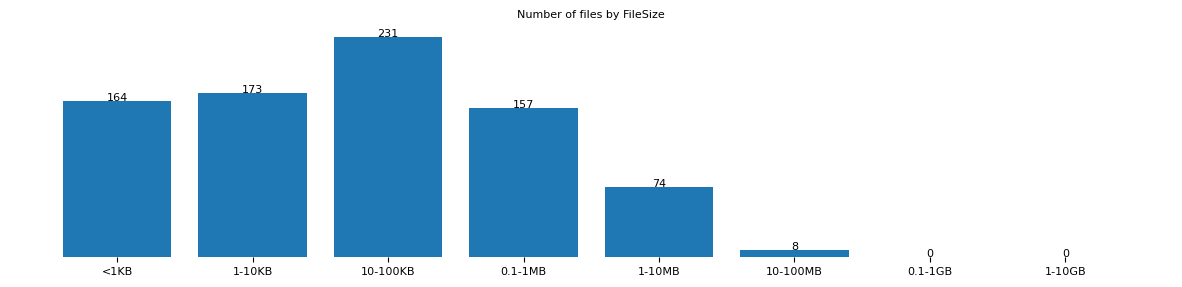

In [106]:
### Count of files by filesize bins
stats_g = data.groupby(['FileSizeBins']).size().reset_index()

### Chart
columnchart('Number of files by FileSize', stats_g['FileSizeBins'], stats_g[0], colour='#1f78b4')


### Total size by council
Naturally, in looking at total size of all files by council, councils which provide the most datafiles would tend to higher total sizes. 

Yet Renfrewshire is an exception here, they are middle of the pack for number of files provided but their total file size far exceeds everyone else. This might be because the filetypes they are using are storage heavy (7 of their 8 filetypes are unique to them and we have no filesize data for other councils using the 1 shared filetype) or they could benefit from file compression in their publishing process.

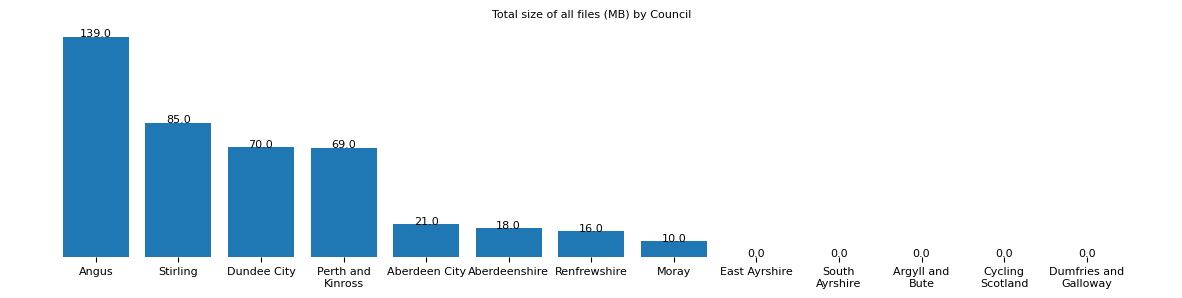

In [107]:
### Filesize totals by council
stats_g1 = data.groupby(['Owner'])['FileSizeBytes'].sum().reset_index()
stats_g1['FileSizeMB'] = stats_g1['FileSizeBytes']/1000000
stats_g1 = stats_g1.sort_values(by=['FileSizeMB'], ascending=False).reset_index(drop=True)

### Chart
columnchart('Total size of all files (MB) by Council', stats_g1['Owner'], stats_g1['FileSizeMB'], colour='#1f78b4')

### Total file size (MB) by Council and FileType

In [108]:
### Total FileSize by FileType
stats_g2 = data.groupby(['Owner','FileType'])['FileSizeBytes'].sum().reset_index()
stats_g2['FileSizeMB'] = stats_g2['FileSizeBytes']/1000000
stats_g2 = stats_g2.sort_values(by=['FileSizeMB'], ascending=False).reset_index(drop=True)
stats_g2

### Total FileSize by Council and FileType, as matrix (rows=filetype, columns=council), ordered by FileType total FileSize
stats_g2_pivot = stats_g2.pivot(index='FileType',columns='Owner', values='FileSizeMB')
stats_g2_pivot.loc[:,'FileType_Total'] = stats_g2_pivot.sum(numeric_only=True, axis=1)
stats_g2_pivot = stats_g2_pivot.sort_values(by='FileType_Total', ascending=False)
stats_g2_pivot.loc['Council_Total']= stats_g2_pivot.sum(numeric_only=True, axis=0)
stats_g2_pivot = stats_g2_pivot.round(2)
stats_g2_pivot = stats_g2_pivot.fillna('')
stats_g2_pivot

Owner,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Cycling Scotland,Dumfries and Galloway,Dundee City,East Ayrshire,Moray,Perth and Kinross,Renfrewshire,South Ayrshire,Stirling,FileType_Total
FileType,,,,,,,,,,,,,,
CSV,5.72,0.73,0.0,,0.0,0.0,43.41,0.01,0.09,59.16,,,81.41,190.54
KML,4.92,,85.86,,,,,,3.7,0.0,,,,94.49
GEOJSON,5.92,,51.01,,,0.0,13.7,,4.2,0.0,,,,74.83
KMZ,,13.56,,,,,,,,,,,,13.56
XLSX,2.14,,0.0,,,,6.38,,,,,,,8.51
HTML,0.37,,0.03,,,,0.19,,,7.33,,,,7.92
WEB MAPPING APPLICATION,,,,,,,,,,,7.24,,,7.24
ZIP,0.92,3.8,,,0.0,0.0,2.08,,,0.0,,,,6.80
IMAGE,,,,,,,,,,,6.41,,,6.41


<a id='tags'></a>
## Dataset Tags


In [109]:
### New dataset: Tags used in the datasets
data_tags = data[['Owner', 'PageURL','OriginalTags','ManualTags']]
data_tags = data_tags.drop_duplicates()
### combine the Original and Manual tags together then split them out
data_tags['AllTags'] = data_tags.apply(lambda x: str(x['OriginalTags'])+ ';' + str(x['ManualTags']), axis=1)
data_tags['AllTags'] = data_tags['AllTags'].str.replace(',',';')
data_tags = data_tags.join(data_tags['AllTags'].str.split(';', expand = True))
### unpivot the table from wide to long format
data_tags = data_tags.drop(columns=['OriginalTags','ManualTags','AllTags'])
data_tags = data_tags.melt(id_vars=['Owner','PageURL'])
### Clean up: remove nones
data_tags = data_tags.drop(data_tags[data_tags['value']=='nan'].index)
data_tags = data_tags.dropna()
### Clean up: remove redundant column and rename the other
data_tags = data_tags.drop(columns=['variable'])
data_tags = data_tags.rename(columns={'value':'Tag'})
### Clean up: set all tags to lowercase and trim
data_tags['Tag'] = data_tags['Tag'].str.lower()
data_tags['Tag'] = data_tags['Tag'].str.strip()

In [135]:
len(set(data_tags['Tag']))

373

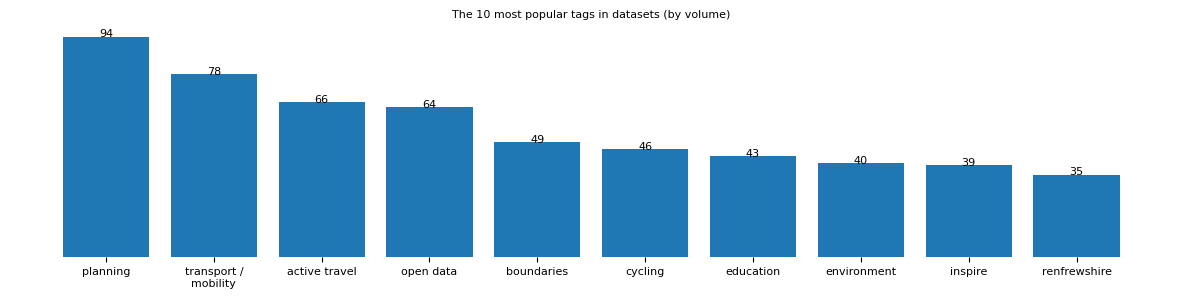

In [110]:
### The 10 most popular tags
stats_d = pd.DataFrame(data_tags['Tag'].value_counts()).head(10)

### Chart
columnchart('The 10 most popular tags in datasets (by volume)', stats_d.index, stats_d['Tag'], colour='#1f78b4')


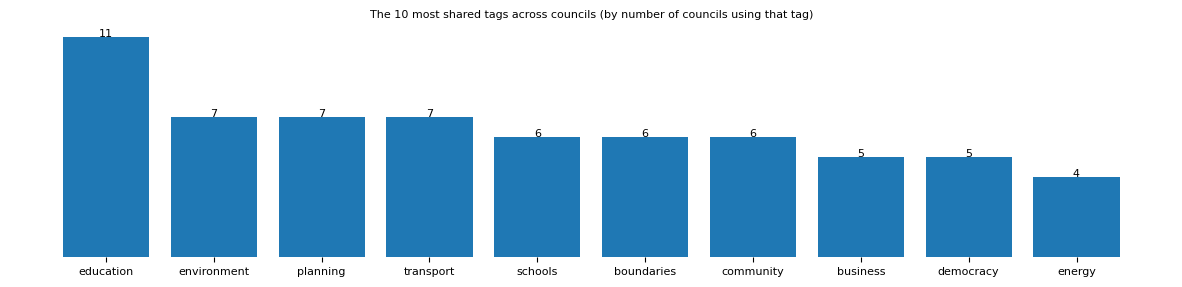

In [111]:
### The 10 most shared tags across councils
stats_d1 = pd.DataFrame(data_tags.groupby(['Tag'])['Owner'].nunique()).sort_values(by=['Owner'],ascending=False).head(10)

### Chart
columnchart('The 10 most shared tags across councils (by number of councils using that tag)', stats_d1.index, stats_d1['Owner'], colour='#1f78b4')


### Tags by council
A high number of unique tags could suggest that a council is providing a wider range of datasets over different interest areas. Or it could also be indicative of a tag-happy staffer who is great at tagging (this is good). 

So conversely, a low number of unique tags by councils should be of concern ---> why are you not tagging?

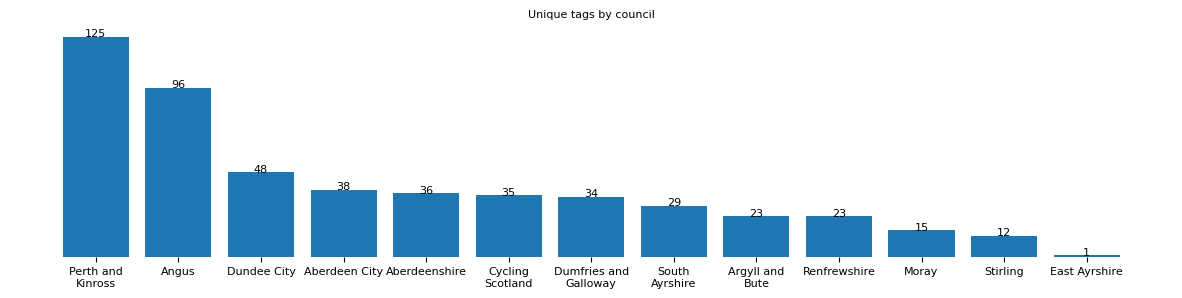

In [112]:
### Number of unique tags by council
stats_d2 = pd.DataFrame(data_tags.groupby(['Owner'])['Tag'].nunique()).sort_values(by=['Tag'],ascending=False)

### Chart
columnchart('Unique tags by council', stats_d2.index, stats_d2['Tag'], colour='#1f78b4')


### A note for the future
It would be very interesting to have a master list of potential tags (that is, areas of interest where OD should be provided for) to then compare how each council is providing data in each of these interest areas

For example, it's clear above that many councils are providing datasets to do with Education, but what about transport and waste management etc?

### Inconsistencies in dataset tags
As with free-text entry fields, we would expect to see issues in quality here. 
We have inconsistencies in format (casing), different tag separators, and typos. But we also have inconsistencies in style of tagging.

For example, see the extract below for the 5 different ways electoral data has been tagged, only 1 is an obvious error, the other 4 are legitimate tags but in different styles. This if anything highlights a need for a shared standardisation in the open data publishing process.

In [113]:
### Matrix of tags used by council
stats_d3 = pd.DataFrame(\
                    data_tags.groupby(['Tag','Owner']).size())\
                .reset_index()\
                .pivot(index='Tag',columns='Owner',values=0)
stats_d3.loc[:,'Tag_Total'] = stats_d3.sum(numeric_only=True, axis=1)
stats_d3.loc['Council_Total',:] = stats_d3.sum(numeric_only=True, axis=0)

### Export to 'output_TagsByCouncil.csv'
stats_d3.to_csv('output_TagsByCouncil.csv')

### Show a snippet for "elec"
elec_tag_list = [t for t in stats_d3.index.values if (t[0:4]=='elec') & (t.find('electric'))]
stats_d3.loc[elec_tag_list,:].fillna('')

Owner,Aberdeen City,Aberdeenshire,Angus,Argyll and Bute,Cycling Scotland,Dumfries and Galloway,Dundee City,East Ayrshire,Moray,Perth and Kinross,Renfrewshire,South Ayrshire,Stirling,Tag_Total
Tag,,,,,,,,,,,,,,
elecorate,,,,,,,,,,1.0,,,,1.0
election,,,,,,,1.0,,,,,,,1.0
elections,,,2.0,,,,,,,,,3.0,,5.0
electoral,,,,3.0,,,,,,,,,,3.0
electorate,,,,,,,,,,1.0,,,,1.0


<a id='licensing'></a>
## Dataset Licensing

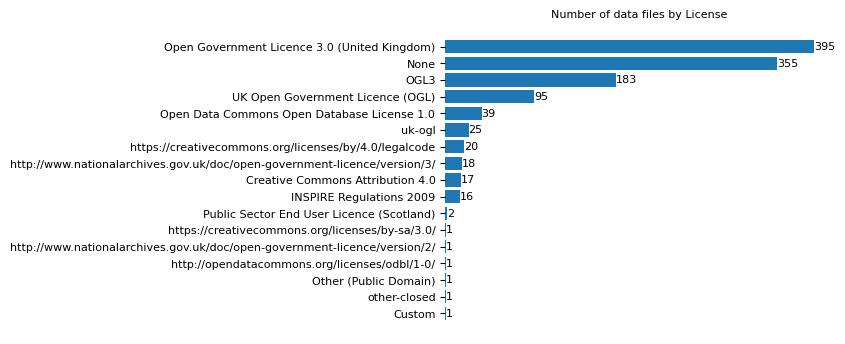

In [114]:
stats_h = pd.DataFrame(data.groupby(['License'], dropna=False).size().sort_values(ascending=True)).reset_index().rename(columns={0:'Count'})
stats_h = stats_h.fillna('None')

plt.figure(figsize=(5,4))
plt.barh(y=stats_h['License'], width=stats_h['Count'])
plt.ylabel(''), plt.xlabel(''), plt.xticks([])
plt.box(False)
for i in range(len(stats_h['License'])):
    y=stats_h['Count']
    plt.text(y[i], i, round(y[i],0), va = 'center')
plt.title('Number of data files by License')
plt.savefig('image_Number of data files by License.png')
plt.show()

### Inconsistencies
We have multiple ways of writing the same thing across councils. See:
- OGL3
- Open Government Licence 3.0 (United Kingdom)
- UK Open Government Licence (OGL)
- uk-ogl 

are all the same thing.

Note that all arcgis API licenses have returned empty - this is likely due to an error in the API call rather than in the datasets themselves.

In [115]:
pd.DataFrame(data.groupby(['Source','License'], dropna=False).size()).reset_index().rename(columns={0:'Count'}).fillna('None')

,Source,License,Count
0,USMART API,OGL3,183
1,USMART API,http://opendatacommons.org/licenses/odbl/1-0/,1
2,USMART API,https://creativecommons.org/licenses/by-sa/3.0/,1
3,USMART API,https://creativecommons.org/licenses/by/4.0/le...,20
4,arcgis API,http://www.nationalarchives.gov.uk/doc/open-go...,1
5,arcgis API,http://www.nationalarchives.gov.uk/doc/open-go...,18
6,arcgis API,None,138
7,ckan API,Creative Commons Attribution 4.0,17
8,ckan API,Open Data Commons Open Database License 1.0,39
9,ckan API,Open Government Licence 3.0 (United Kingdom),322


<a id='urls'></a>
## Check URL statuses
Checks to see if our urls are active or if the file for some reason has been removed. 

In [116]:
### shows progress indicator for slow processes.
def progress_indicator(n,jump,**kwargs):
### n is the current instance, jump is the instance increment to highlight, as is jump2 (e.g. show every 10 and 100). jump2 is optional.
    jump2 = kwargs.get('jump2', None)

    ### if the remainder of n/jump2 = 0 (i.e. a whole number)
    if (n>0) & (n%jump2 == 0):
        ### print the quotient + string marker
        print(str(n//jump2)+'00', end='', flush=True)
    ### otherwise print a * for every jump
    elif n%jump == 0:
        print('*', end='', flush=True)
    return

### get web status for assetURL
def check_status(url):
    try:
        response = requests.get(url)
        status = (response.status_code == 200)
    except:
        status = 'Error'
    return status

In [117]:
### This is a very very very slow process. It can take >10 minutes to check 800 urls. 
### I recommend skipping this if you're doing a light update.
### But if you want to get updated statuses (and wait for a while), type "IMSURE" when prompted.
### There is a progress indicator and confirmation at end.

are_you_sure = input("Update URL statuses: This is a very slow process, be prepared to wait over 10mins. To go ahead type IMSURE")

if are_you_sure == 'IMSURE':
    for row in data.index:
        data.loc[row,'AssetStatus'] = check_status(data.loc[row,'AssetURL'])
        progress_indicator(row,10,jump2=100)
    
    print('\nok done. Last updated',dt.datetime.now().strftime(format='%d-%m-%Y %Hh:%Mm'))
    print(data['AssetStatus'].value_counts())

else:
    print('url status check skipped.')

**********100*********200*********300*********400*********500*********600*********700*********800*********900*********1000*********1100*******
ok done. Last updated 19-02-2022 17h:01m
True     972
Error    158
False     41
Name: AssetStatus, dtype: int64


## URL statuses by Council
This shows if the URL of OD assets are active (True) or not (False).
If it is True, the data is accessible, if it is False there is a hosting issue.
(Error) indicates there is no URL to check or it is missing from our data.

A full listing of the URL status is available in 'output_AllAnalytics.csv'

In [118]:
pd.DataFrame(data.groupby(['Owner','AssetStatus']).size())\
        .reset_index()\
        .pivot(index='Owner',columns='AssetStatus',values=0)\
        .fillna('')\
        .rename(columns={False:'Inactive',True:'Active','Error':'Missing'})\
        [['Active','Inactive','Missing']]



AssetStatus,Active,Inactive,Missing
Owner,,,
Aberdeen City,92.0,,
Aberdeenshire,30.0,3.0,
Angus,71.0,24.0,1.0
Argyll and Bute,,,20.0
Cycling Scotland,136.0,2.0,
Dumfries and Galloway,65.0,2.0,
Dundee City,177.0,4.0,
East Ayrshire,4.0,,
Moray,57.0,,62.0


<a id='summary'></a>
# Summary Matrix
All the characteristics, in one place.

In [119]:
data.to_csv('output_AllAnalytics.csv')

In [120]:
summary_matrix = pd.DataFrame(data.groupby(['Owner'])['AssetURL'].size()).reset_index()
summary_matrix = summary_matrix.merge(data[data['AssetStatus']==True].groupby(['Owner'])['AssetStatus'].size().reset_index(), how='left', on='Owner')
summary_matrix['% Active URLs'] = summary_matrix['AssetStatus']/summary_matrix['AssetURL']
summary_matrix['% Active URLs'] = round(summary_matrix['% Active URLs']*100,1)
summary_matrix = summary_matrix.merge(stats_a, how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['Source'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.dropna(subset=['DateUpdated']).groupby(['Owner'])['DateUpdated'].max().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['License'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data_tags.groupby(['Owner'])['Tag'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(data.groupby(['Owner'])['FileType'].nunique().reset_index(), how='left', on='Owner')
summary_matrix = summary_matrix.merge(stats_e, how='left', on='Owner')
summary_matrix = summary_matrix.merge(stats_g1[['Owner','FileSizeMB']], how='left', on='Owner')
summary_matrix['FileType_y'] = round(summary_matrix['FileType_y'],2)
summary_matrix['FileSizeMB'] = round(summary_matrix['FileSizeMB'],2)
column_rename = {'Owner':'Council',
                 'AssetURL':'#Files',
                 'AssetStatus':'Active URLs',
                 'Count':'#Datasets',
                 'Source':'#Data Sources',
                 'DateUpdated':'Last Updated',
                 'License':'#Licenses',
                 'Tag':'#Tags',
                 'FileType_x':'#FileTypes',
                 'FileType_y':'Avg FileTypes per Dataset',
                 'FileSizeMB':'Total Size (MB)'}
summary_matrix = summary_matrix.rename(columns=column_rename)
summary_matrix.to_csv('output_SummaryMatrix.csv', index=False)
summary_matrix.fillna('')


,Council,#Files,Active URLs,% Active URLs,#Datasets,#Data Sources,Last Updated,#Licenses,#Tags,#FileTypes,Avg FileTypes per Dataset,Total Size (MB)
0,Aberdeen City,92,92.0,100.0,16,1,2020-09-22,1,38,7,3.81,20.64
1,Aberdeenshire,33,30.0,90.9,31,1,2021-06-01,2,36,3,1.06,18.10
2,Angus,96,71.0,74.0,34,1,2021-12-23,2,96,9,2.44,139.35
3,Argyll and Bute,20,,,20,1,2021-08-03,0,23,1,1.00,0.00
4,Cycling Scotland,138,136.0,98.6,77,1,2022-02-17,4,35,7,1.81,0.00
5,Dumfries and Galloway,67,65.0,97.0,32,1,2021-12-03,1,34,5,2.09,0.00
6,Dundee City,181,177.0,97.8,37,1,2022-02-10,5,48,12,1.89,69.55
7,East Ayrshire,4,4.0,100.0,4,1,,1,1,1,1.00,0.01
8,Moray,119,57.0,47.9,73,2,2021-02-02,2,15,5,1.28,9.99
9,Perth and Kinross,265,259.0,97.7,64,1,2022-02-13,4,125,9,3.94,69.10


<a id='scorecard'></a>
# Scorecard

Everything we’ve looked at so far is descriptive and explanatory. It helps us figure out what’s going on but how do we make this useful and actionable?

One way is to turn it into a competition to score and rank each council to see how they're all stacking up. It's not perfect, but it's one way of consistently and transparently measuring everyone. This isn't a measure of if the council is rated "good" or not, this is just an ordering from best offerings to worst, where the worst offering is having no open data provision at all. This could be a way to identify who the leader councils are for other councils to emulate, but that doesn't exclude the need for leading councils to improve their offering either.

The scorecare can be a great tool to potentially facilitate a lot of conversation. If a council asks "so how do we get a better score?", well, where are you performing worst at the moment? What's the easiest thing to fix right now?
- if you post a new dataset next week your score could improve significantly.
- Could you relabel some of your existing datasets, that could be a way to improve your score?



## Methodology
The idea behind the scorecard is to encourage and reward good behaviour: having a lot of datasets, a high variety of filetypes, a high variety of datasets, and timeliness (!) etc...


There are 10 areas of assessment, each with a potential score of 0-1 and come from either of 2 scoring mechanisms:
- an objective binary measure: Did they meet this critera Yes(1)/No(0)
- a relative measure: Who is best in this area (1), and worst (0), everyone else gets between 0-1 based on rank.

| Measure | Scoring  | Goal  |
|:--|:--|:--|
| Has OD Site  | objective  |  Is providing some OD |
| #Datasets |  relative | More datasets are better  |
| % Active URLs  |  relative |  More active links are better |
| Last 365 days |  objective | Has updated data in the last year |
| Last 180 days |  objective | Has updated data in the last 6 months |
| Last 90 days |  objective | Has updated data in the last 3 months |
| Last 30 days |  objective | Has updated data in the last month |
| Avg FileTypes per Dataset  |  relative | Higher avg filetypes suggests better variety and accomodations |
| Total Size (MB)  |  relative | Higher size might suggest more data available |
| #Tags  |  relative | More tags might suggest broader range of categories offered |

The highest possible perfect score is 10.

In [121]:
# Calculating Last updated

def days_updated(df):
    last_update = df[['Council','Last Updated']].copy()
    last_update['Days_Passed'] = last_update['Last Updated'].apply(lambda x: (dt.date(2021,6,27) - x).days if isinstance(x, dt.date) else None)
    #last_update['Days_Passed'] = last_update['Last Updated'].apply(lambda x: (dt.datetime.today().date() - x).days if isinstance(x, dt.date) else None)
    last_update['Last 365 days'] = last_update['Days_Passed'] < 365
    last_update['Last 180 days'] = last_update['Days_Passed'] < 180
    last_update['Last 90 days'] = last_update['Days_Passed'] < 90
    last_update['Last 30 days'] = last_update['Days_Passed'] < 30
    last_update = last_update.drop(columns=['Last Updated','Days_Passed'])

    return last_update

In [122]:
### Putting the scorecard together

scorecard = data_localauthorities.copy()
### Has OD site
scorecard['Has OD Site'] = scorecard['Council'].isin(set(summary_matrix['Council']))
### Unique datasets
scorecard = scorecard.merge(summary_matrix[['Council','#Datasets']], how='left', on='Council')
scorecard['#Datasets'] = round(scorecard['#Datasets'].rank()/len(summary_matrix),2)
### % Active URLS
scorecard = scorecard.merge(summary_matrix[['Council','% Active URLs']], how='left', on='Council')
scorecard['% Active URLs'] = round(scorecard['% Active URLs'].rank()/len(summary_matrix),2)
### Last updates in 365, 180, 90, 30 days
scorecard = scorecard.merge(days_updated(summary_matrix), how='left', on='Council')
### Filetypes per dataset
scorecard = scorecard.merge(summary_matrix[['Council','Avg FileTypes per Dataset']], how='left', on='Council')
scorecard['Avg FileTypes per Dataset'] = round(scorecard['Avg FileTypes per Dataset'].rank()/len(summary_matrix),2)
### Total filesize
scorecard = scorecard.merge(summary_matrix[['Council','Total Size (MB)']], how='left', on='Council')
scorecard['Total Size (MB)'] = round(scorecard['Total Size (MB)'].rank()/len(summary_matrix),2)
### Unique tags used
scorecard = scorecard.merge(summary_matrix[['Council','#Tags']], how='left', on='Council')
scorecard['#Tags'] = round(scorecard['#Tags'].rank()/len(summary_matrix),2)

### Cleanup
scorecard = scorecard.fillna(0)
scorecard = scorecard.replace([True,False], [1,0])
scorecard.loc[:,'Council_Score'] = scorecard.sum(numeric_only=True, axis=1)
scorecard = scorecard.sort_values(by='Council_Score', ascending=False).set_index('Council')

scorecard.to_csv('output_Scorecard.csv')
scorecard


,Has OD Site,#Datasets,% Active URLs,Last 365 days,Last 180 days,Last 90 days,Last 30 days,Avg FileTypes per Dataset,Total Size (MB),#Tags,Council_Score
Council,,,,,,,,,,,
Perth and Kinross,1,0.85,0.38,1,1,1,1,0.92,0.69,0.92,8.76
Dundee City,1,0.69,0.46,1,1,1,1,0.62,0.77,0.77,8.31
Angus,1,0.54,0.15,1,1,1,1,0.77,0.92,0.85,8.23
Stirling,1,0.27,0.62,1,1,1,1,0.46,0.85,0.15,7.35
Aberdeenshire,1,0.38,0.23,1,1,1,1,0.38,0.54,0.62,7.15
Dumfries and Galloway,1,0.46,0.31,1,1,1,1,0.69,0.15,0.54,7.15
Renfrewshire,1,0.77,0.00,1,1,1,1,0.19,0.46,0.35,6.77
South Ayrshire,1,0.62,0.00,1,1,1,1,0.19,0.15,0.46,6.42
Argyll and Bute,1,0.27,0.00,1,1,1,1,0.19,0.15,0.35,5.96


## A note on methodology
Opportunities to make a better scorecard.

### Relative measures
How do you score things like "do you have a lot of datasets?" because what is a lot? Is 10 enough, 100, 1000? Because there isn't any objective measure, the best we can do is consider any one council in the context of all the other councils. That is, I don't know if 100 is enough, but 100 is the most anyone else has got so you get the perfect score of 1 in this area, and if you have the least number of datasets available, you get the perfect score of 0, everyone else gets a score in between 0-1.

There is of course opportunity to convert many of these relative measures into objective measures, but these should be discussed and agreed (and we invite participation because they need to be realistic and achievable). For example, we can set an objective measure such as: Council has more than 20 unique datasets (Yes/No).

### Weightings
All of these scores are equally weighted, but some areas appear more frequently than others which lends it an implied weighting. This was deliberate in measuring timeliness where in effect, if you have an updated dataset in the last 30 days you get 4 points and 1 point if it is only updated in the last 6 months to year.

Yet something like % Active URLS (which offers a max of 1 point for this area), should maybe work in negative effect if you get anything less than 100% (True or Error). i.e. if you have links that are broken, so a dataset appears to be available but it is not, that is indicative of poor maintenance practice and should probably be penalised more than if an organisation had fewer datasets but all datasets were maintained and accessible. (or convert % Active URLs into an objective measure e.g. >90% of links are active, Yes/No.)